<a href="https://colab.research.google.com/github/alex-pakalniskis/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 




In [0]:
# TODO - code!

In [0]:
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  return (true_positive_rate * prob_drunk_prior) / ((true_positive_rate * prob_drunk_prior) + (false_positive_rate * (1 - prob_drunk_prior)))

In [4]:
probability_a_person_is_drunk_after_one_positive_breathalyzer_test = prob_drunk_given_positive(prob_drunk_prior=1/1000, 
                                                                                               
                                                                                               false_positive_rate=0.08, 
                                                                                               
                                                                                               true_positive_rate=1.0)

probability_a_person_is_drunk_after_one_positive_breathalyzer_test

0.012357884330202669

- What is the probability that a person is drunk after two positive breathalyzer tests?
 

In [5]:
probability_a_person_is_drunk_after_two_positive_breathalyzer_tests = prob_drunk_given_positive(prob_drunk_prior=probability_a_person_is_drunk_after_one_positive_breathalyzer_test, 
                                                                                                
                                                                                                false_positive_rate=0.08, 
                                                                                                
                                                                                                true_positive_rate=1.0)

probability_a_person_is_drunk_after_two_positive_breathalyzer_tests

0.13525210993291495

- How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

In [6]:
probability_a_person_is_drunk_after_three_positive_breathalyzer_tests = prob_drunk_given_positive(prob_drunk_prior=probability_a_person_is_drunk_after_two_positive_breathalyzer_tests, 
                                                                                                
                                                                                                false_positive_rate=0.08, 
                                                                                                
                                                                                                true_positive_rate=1.0)

probability_a_person_is_drunk_after_three_positive_breathalyzer_tests

0.6615996951348605

In [7]:
probability_a_person_is_drunk_after_four_positive_breathalyzer_tests = prob_drunk_given_positive(prob_drunk_prior=probability_a_person_is_drunk_after_three_positive_breathalyzer_tests, 
                                                                                                
                                                                                                false_positive_rate=0.08, 
                                                                                                
                                                                                                true_positive_rate=1.0)

probability_a_person_is_drunk_after_four_positive_breathalyzer_tests

0.9606895076105054

Four positive breathalyzer tests are required to have a probability greater than 95% that a person is drunk beyond the legal limit.

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)



In [0]:
# TODO - code!

In [0]:
import pandas as pd

import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

In [17]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"

data_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

df = pd.read_csv(data_url, names=data_headers)
df = df.replace({"y":1,"n":0,"?":np.NaN})
republicans = df[df["party"] == "republican"]
republicans.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


Generate random sample of republican votes for the "aid-to-contras" issue

In [0]:
republican_sample = republicans["aid-to-contras"].sample(frac=0.2)

In [84]:
len(republican_sample)

34

Use functions to calculate confidence intervals

In [0]:
def frequentist_confidence_interval(sample, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    sample - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (lower bound, mean, upper bound)
  """
  # Broadcast to NumPy array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Sample mean
  mean = np.mean(sample)
  # Sample size
  n = len(sample)
  # Standard error
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # T-statistic that contains 95% of possible sample means within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Margin of error 
  margin_of_error = t * stderr
  return mean - margin_of_error, mean, mean + margin_of_error

In [23]:
frequentist_confidence_interval(republican_sample)

(0.0038552050900188956, 0.125, 0.2461447949099811)

In [0]:
def bayesian_confidence_interval(sample, confidence=0.95):
  """
  Calculate a Bayesian confidence interval around a sample mean for given data.
  
  Arguments:
    sample - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, (lower bound, upper bound))
  """
  # Broadcast to NumPy array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Calculate bayesian confidence interval
  results = stats.bayes_mvs(sample, alpha=confidence)[0]
  # Slice results to match tuple produced by frequentist_confidence_interval function
  return results[1][0], results[0], results[1][1]


In [44]:
bayesian_confidence_interval(republican_sample)

(0.0038552050900188817, 0.125, 0.24614479490998112)

Plot results comparing frequentist and Bayesian approaches

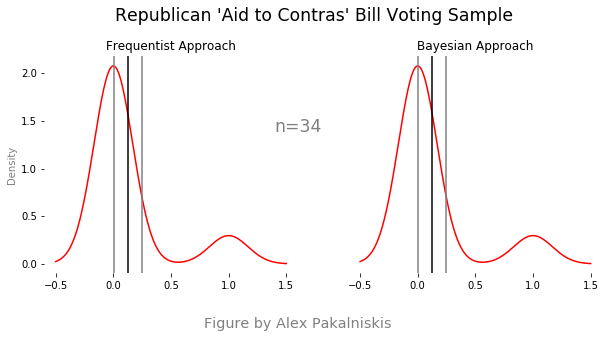

In [117]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

republican_sample.plot.density(color="red", ax=ax[0])
republican_sample.plot.density(color="red", ax=ax[1])

plt.suptitle("Republican 'Aid to Contras' Bill Voting Sample", size="xx-large", y=1.05)

ax[0].set_title("Frequentist Approach")
ax[0].axvline(x=frequentist_confidence_interval(republican_sample)[0], color='gray')
ax[0].axvline(x=frequentist_confidence_interval(republican_sample)[1], color='black')
ax[0].axvline(x=frequentist_confidence_interval(republican_sample)[2], color='gray')

ax[1].set_title("Bayesian Approach")
ax[1].axvline(x=bayesian_confidence_interval(republican_sample)[0], color='gray')
ax[1].axvline(x=bayesian_confidence_interval(republican_sample)[1], color='black')
ax[1].axvline(x=bayesian_confidence_interval(republican_sample)[2], color='gray')

## Remove figure spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

## Remove select tick marks and axis labels
ax[0].tick_params(bottom="off", left="off")
ax[1].set_yticks([])
ax[1].set_ylabel("")
ax[0].set_ylabel("Density",color="gray")

plt.text(ha="center",x=1,y=0.65, s="n="+str(len(republican_sample)), transform=ax[0].transAxes, size="xx-large", color="gray")

plt.text(ha="center",x=1,y=-0.25, s="Figure by Alex Pakalniskis", transform=ax[0].transAxes, size="x-large", color="gray")

plt.show()

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).




Response: Frequentist and Bayesian schools of thought differ in how they view probability. Frequentist don't assign prior probabilities to events, instead relying on repeated observation of event frequencies (sample data) to drive inferences. Bayesians posit a prior probability (ideally informed by earlier research) to events, then update likelihoods according to sample data.  

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!

In [0]:
def sample_confidence_intervals(pandas_series, sample_size, confidence=0.95):
  # Sample the input Series
  sample = pandas_series.sample(int(sample_size))
# Broadcast to NumPy array
  sample = np.array(sample)
  # Remove NaN values
  sample = sample[~np.isnan(sample)]
  # Sample mean
  mean = np.mean(sample)
  # Sample size
  n = len(sample)
  # Standard error
  stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # T-statistic that contains 95% of possible sample means within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Frequentist 
  f_margin_of_error = t * stderr
  # Bayesian
  bayes_results = stats.bayes_mvs(sample, alpha=confidence)[0]
  # Slice results to match tuple produced by frequentist_confidence_interval function
  confidence_interval_results =  mean, f_margin_of_error, bayes_results[0], bayes_results[1][1]-bayes_results[0]
  return confidence_interval_results

In [145]:
sample_confidence_intervals(republicans["aid-to-contras"], 50)

(0.1276595744680851,
 0.0990403187252286,
 0.1276595744680851,
 0.09904031872522859)

In [142]:
issues = df.drop(["party"], axis=1).columns.tolist()
issues

['handicapped-infants',
 'water-project',
 'budget',
 'physician-fee-freeze',
 'el-salvador-aid',
 'religious-groups',
 'anti-satellite-ban',
 'aid-to-contras',
 'mx-missile',
 'immigration',
 'synfuels',
 'education',
 'right-to-sue',
 'crime',
 'duty-free',
 'south-africa']

In [143]:
republicans_CI = []

for i in range(len(issues)):
  
  republicans_CI.append(sample_confidence_intervals(republicans[issues[i]], 
                                    
                                                    len(republicans)*0.25))

republicans_confidence_intervals_df = pd.DataFrame(republicans_CI, 
                                                    
                                                   columns=["Frequentist Mean",
                                                             
                                                            "Frequentist Margin of Error", 
                                                            
                                                            "Bayesian Mean", 
                                                            
                                                            "Bayesian Margin of Error"])
  
republicans_confidence_intervals_df["issue"] = pd.Series(issues)

republicans_confidence_intervals_df["party"] = "Republican"

  
republicans_confidence_intervals_df

,Frequentist Mean,Frequentist Margin of Error,Bayesian Mean,Bayesian Margin of Error,issue,party
0,0.268293,0.141588,0.268293,0.141588,handicapped-infants,Republican
1,0.594595,0.165956,0.594595,0.165956,water-project,Republican
2,0.073171,0.083219,0.073171,0.083219,budget,Republican
3,0.976190,0.048084,0.976190,0.048084,physician-fee-freeze,Republican
4,0.902439,0.094820,0.902439,0.094820,el-salvador-aid,Republican
5,0.928571,0.081228,0.928571,0.081228,religious-groups,Republican
6,0.268293,0.141588,0.268293,0.141588,anti-satellite-ban,Republican
7,0.210526,0.135801,0.210526,0.135801,aid-to-contras,Republican
8,0.119048,0.102140,0.119048,0.102140,mx-missile,Republican
9,0.536585,0.159352,0.536585,0.159352,immigration,Republican


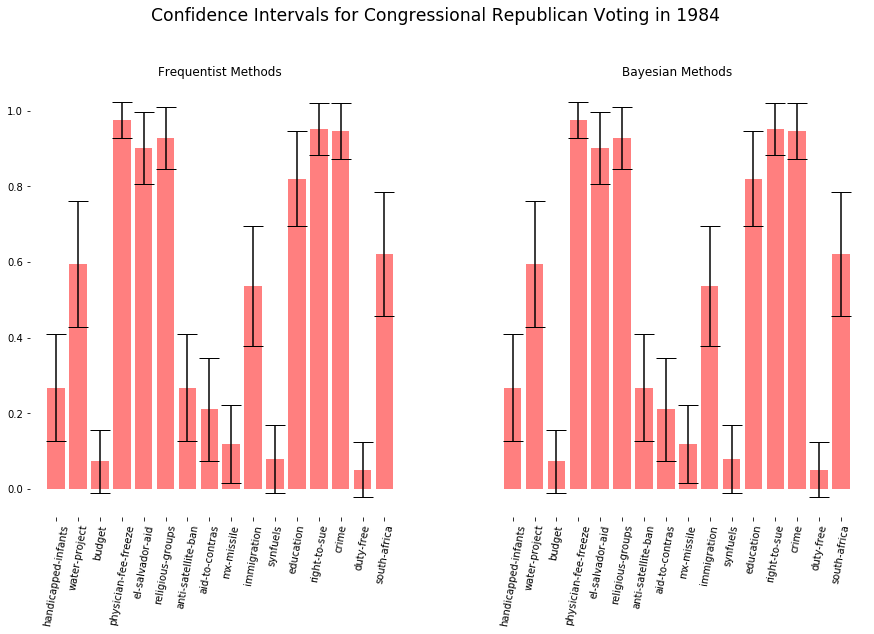

In [187]:
#republicans_confidence_intervals_df = republicans_confidence_intervals_df.set_index("issue")

fig, ax = plt.subplots(1,2,figsize=(15,8))

ax[0].bar(republicans_confidence_intervals_df.index, republicans_confidence_intervals_df["Frequentist Mean"],
       yerr=republicans_confidence_intervals_df["Frequentist Margin of Error"],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10, facecolor="red")

ax[1].bar(republicans_confidence_intervals_df.index, republicans_confidence_intervals_df["Bayesian Mean"],
       yerr=republicans_confidence_intervals_df["Bayesian Margin of Error"],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10, facecolor="red")



plt.suptitle("Confidence Intervals for Congressional Republican Voting in 1984", size="xx-large", y=1.01)
ax[0].set_title("Frequentist Methods")
ax[1].set_title("Bayesian Methods")
ax[1].set_yticks([])

 ## Remove figure spines
for ax in [ax[0],ax[1]]:
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_xticks(republicans_confidence_intervals_df.index)
  ax.set_xticklabels(republicans_confidence_intervals_df.index, rotation=80)




plt.show()